In [21]:
from analyze_language_change import import_corpus, linear_prediction, occurrence_freq_by_year

import pandas as pd
from itertools import chain
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np 

In [22]:
corpus_12_25 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau")

In [23]:
"""
corpus_18_23 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-2018-2023")
corpus_24 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-010124-020524")
corpus_17 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau-2017")

corpus = chain(corpus_17, corpus_18_23, corpus_24)
"""

'\ncorpus_18_23 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-2018-2023")\ncorpus_24 = import_corpus(batch_size=100, streaming=False, url="bjoernp/tagesschau-010124-020524")\ncorpus_17 = import_corpus(batch_size=100, streaming=False, url="julilili42/tagesschau-2017")\n\ncorpus = chain(corpus_17, corpus_18_23, corpus_24)\n'

In [24]:
rows = [(a.date.year, a.article) for a in corpus_12_25]
year, articles = zip(*rows)

31972 articles to be loaded for dataset tagesschau


In [25]:
# distribution of articles for years
year_distribution = pd.Series(year).value_counts().sort_index()
# generate word matrix 
vec = CountVectorizer(max_features=100000, binary=True)
word_matrix_bin = vec.fit_transform(articles)
vocab = vec.get_feature_names_out()

Text(0, 0.5, 'Number of articles')

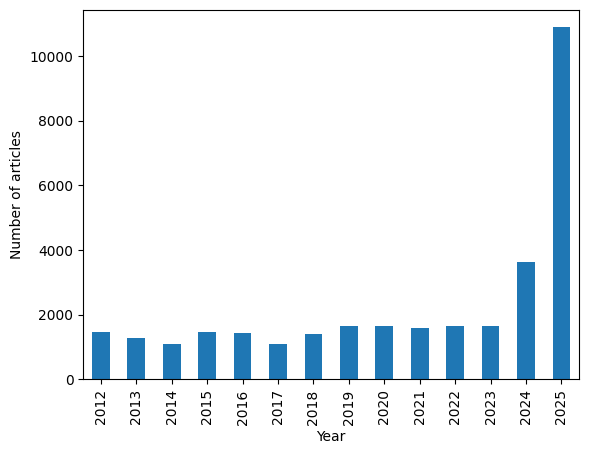

In [26]:
ax = year_distribution.plot(kind="bar")
ax.set_xlabel("Year")
ax.set_ylabel("Number of articles")

In [27]:
occurence_freq = occurrence_freq_by_year(year=year, word_matrix_bin=word_matrix_bin, vocab=vocab)

Goal: try to find words which disproportionaly increased in use, by interpolating use in year 2024 

- frequency gap $\delta = p - q$ $\implies$ highlights excess usage of frequent words
- frequency ratio $r = \frac{p}{q}$ $\implies$ highlights excess usage of infrequent words.

In [28]:
# dataframe containing frequencies before introduction of llm's
train = occurence_freq.loc[2012:2022]

# linear interpolation, frequency value of 2024
q = train.apply(linear_prediction, axis=0)

# empirical frequency
p = occurence_freq.loc[2024]

# only keep words with p>1e-4 in 2023 and 2024
mask_freq = (occurence_freq.loc[2023] > 1e-4) & (occurence_freq.loc[2024] > 1e-4)
p = p[mask_freq]
q = q[mask_freq]

# Metric 1: frequency gap delta = p - q
delta = p - q

# Metric 2: frequency ratio r = p/q
eps = 1e-8
r = p / np.maximum(q, eps)

sorted_freq_gap = delta.sort_values(ascending=False).head(20)
sorted_freq_ratio = r.sort_values(ascending=False).head(20)

Definition Excess Words: 
- $\delta > 0.01$ and 
- $\log_{10}\;r > \frac{log_{10}\;2}{4} \cdot log_{10}\;p$

In [29]:
threshold = (np.log10(2) / 4) * np.log10(p)
mask_excess = (delta > 0.01) | (np.log10(r) > threshold)

excess_words = pd.DataFrame({
    "p": p,
    "q": q,
    "delta": delta,
    "r": r
}).loc[mask_excess].sort_values("delta", ascending=False)

print("number of excess words:", len(excess_words))
print(excess_words.head(20))

number of excess words: 32396
                           p         q     delta         r
2023                0.203250  0.040160  0.163090  5.061031
euro                0.250069  0.101407  0.148662  2.465990
2024                0.143487  0.027589  0.115898  5.200925
prozent             0.367116  0.265972  0.101144  1.380280
milliarden          0.157257  0.056422  0.100835  2.787152
teilte              0.215643  0.119954  0.095689  1.797710
sagte               0.523823  0.429402  0.094421  1.219889
nachrichtenagentur  0.180942  0.086882  0.094060  2.082608
zufolge             0.271551  0.180861  0.090689  1.501431
2025                0.117598  0.027160  0.090438  4.329835
social              0.110438  0.021731  0.088707  5.082000
hieß                0.187276  0.102279  0.084997  1.831026
chef                0.199945  0.115694  0.084251  1.728228
media               0.107959  0.023997  0.083962  4.498899
regierung           0.324704  0.242221  0.082483  1.340526
israel              0.1063

In [31]:
# only look at adjectives and verbes
import spacy
nlp = spacy.load("de_core_news_lg")

words = list(excess_words.index)
pos_tags = {}
for doc in nlp.pipe(words, batch_size=500):
    token = doc[0]
    pos_tags[token.text] = token.pos_

allowed_pos = {"ADJ", "VERB"}
style_words = [w for w, pos in pos_tags.items() if pos in allowed_pos]

excess_style_words = excess_words.loc[excess_words.index.isin(style_words)].sort_values("r", ascending=False)

print(f"number of excess style words {len(excess_style_words)}")
print(excess_style_words.head(30))

number of excess style words 12276
                          p    q     delta             r
gesenkt            0.021757  0.0  0.021757  2.175709e+06
schulden           0.019003  0.0  0.019003  1.900303e+06
sinkende           0.014597  0.0  0.014597  1.459653e+06
spanische          0.013219  0.0  0.013219  1.321950e+06
nordkoreanischer   0.012944  0.0  0.012944  1.294409e+06
niedrigsten        0.011292  0.0  0.011292  1.129166e+06
palästinensischer  0.010741  0.0  0.010741  1.074084e+06
angegriffene       0.010190  0.0  0.010190  1.019003e+06
dauerhaften        0.009915  0.0  0.009915  9.914624e+05
festgehaltenen     0.009639  0.0  0.009639  9.639218e+05
gestürzten         0.009639  0.0  0.009639  9.639218e+05
konjunkturdaten    0.008813  0.0  0.008813  8.812999e+05
ägyptischen        0.008538  0.0  0.008538  8.537593e+05
geschrumpft        0.008538  0.0  0.008538  8.537593e+05
vereinbarten       0.008262  0.0  0.008262  8.262187e+05
einschnitte        0.007987  0.0  0.007987  7.986781e